In [1]:
import MGTomo.model as mgmodel
import numpy as np
import time
import MGTomo.tomoprojection as mgproj
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize

import torch
import torch.nn.functional as F
from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

from MGTomo import optimize
from MGTomo import gridop

from MGTomo.utils import myexp

In [6]:
N = 255
# load image
x_orig = data.shepp_logan_phantom()
x_torch = torch.tensor(resize(x_orig, (N,N), anti_aliasing = False), requires_grad = True)

In [3]:
max_levels = 1
maxIter = [5,5]

In [7]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [5]:
fH = lambda x: fcts.kl_distance(x, A[1], b[1])

tauH = 1/200

In [6]:
def BSMART_general(f, x: torch.tensor, logv, tau, l, u):
    x = x.clone().detach().requires_grad_(True)
    fx = f(x)
    fx.backward(retain_graph = True)

    with torch.no_grad():
        logv_new = logv -tau * x.grad
        xminl = (u-l) * torch.exp(logv_new - F.softplus(logv_new))
        x_new = xminl + l

        assert torch.all(x_new >= l)
        assert torch.all(x_new <= u)

    if (f(x_new) - fx).abs() < 1e-2*5:
        return x, logv
    
    return x_new, logv_new

In [7]:
xh = torch.rand(N, N)
xh.requires_grad_(True)
xH = gridop.R(xh).detach().requires_grad_(True)

P_inf = 8

lh = torch.zeros_like(xh)
uh = torch.ones_like(xh)

lH, uH = optimize.box_bounds(xh, xH, P_inf, lh, uh)

In [8]:
assert torch.all(xH > lH)
assert torch.all(xH < uH)

logv_new = torch.log((xH - lH)/(uH - xH))

for i in range(100):
    xH, logv_new = BSMART_general(fH, xH, logv_new, tauH, lH, uH)
    xH = xH.clone().detach().requires_grad_(True)

(array([1.6094e+04, 2.3000e+01, 5.0000e+00, 3.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.00000000e+00, 3.14712520e-06, 6.29425040e-06, 9.44137537e-06,
        1.25885008e-05, 1.57356262e-05, 1.88827507e-05, 2.20298771e-05,
        2.51770016e-05, 2.83241279e-05, 3.14712524e-05]),
 <BarContainer object of 10 artists>)

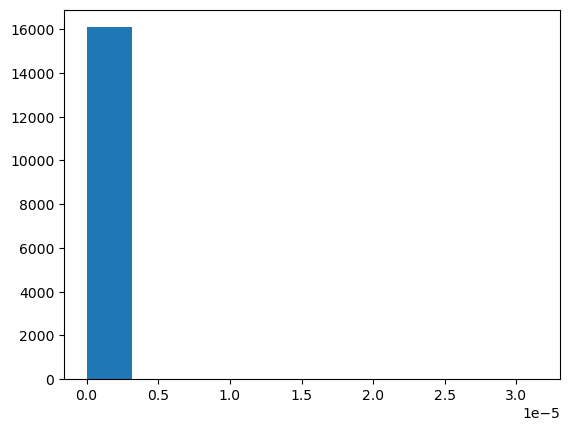

In [9]:
plt.hist(torch.flatten(xH-lH).detach().numpy())

(array([2954., 4649., 3820., 2408., 1352.,  626.,  229.,   70.,   15.,
           6.]),
 array([0.0002594 , 0.01053038, 0.02080135, 0.03107233, 0.04134331,
        0.05161428, 0.06188526, 0.07215624, 0.08242722, 0.09269819,
        0.10296917]),
 <BarContainer object of 10 artists>)

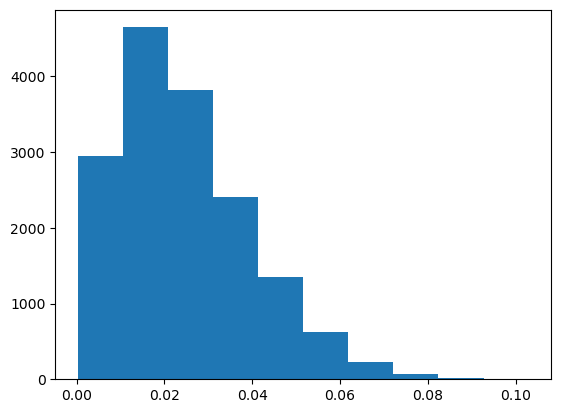

In [10]:
plt.hist(torch.flatten(uH - xH).detach().numpy())